In [ ]:
'''
author: 梁泽涛，叶文涛
create time: 2020-6-30
update time: 2020-7-23
'''

In [2]:
import numpy as np
import pandas as pd

import catboost as cbt

import os,gc,time,re
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 用的是 date preprocess 中初筛数据
%time train_data = pd.read_pickle('data/clean_data1.pkl')
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])

Wall time: 12.7 s


In [3]:
train_data

,loadingOrder,carrierName,timestamp,longitude,latitude,vesselMMSI,speed,direction,vesselNextport,vesselNextportETA,vesselStatus,vesselDatasource,TRANSPORT_TRACE,diff_dist,diff_sec
0,AA191175561416,OIEQNT,2019-01-28 16:12:59+00:00,114.260392,22.571047,Y7540547327,0,12670,HK HKG >CN YTN,2019-01-28T05:30:00.000Z,moored,Coastal AIS,CNYTN-MXZLO,NaN,NaN
1,AA191175561416,OIEQNT,2019-01-28 16:22:38+00:00,114.260438,22.571125,Y7540547327,0,14790,HK HKG >CN YTN,2019-01-28T05:30:00.000Z,moored,Coastal AIS,CNYTN-MXZLO,0.009887,579.0
2,AA191175561416,OIEQNT,2019-01-28 16:30:55+00:00,114.260693,22.571567,Y7540547327,0,21510,HK HKG >CN YTN,2019-01-28T05:30:00.000Z,moored,Coastal AIS,CNYTN-MXZLO,0.055750,497.0
3,AA191175561416,OIEQNT,2019-01-28 16:37:35+00:00,114.260392,22.571463,Y7540547327,0,19900,HK HKG >CN YTN,2019-01-28T05:30:00.000Z,moored,Coastal AIS,CNYTN-MXZLO,0.033036,400.0
4,AA191175561416,OIEQNT,2019-01-28 16:45:56+00:00,114.260647,22.571510,Y7540547327,0,21360,HK HKG >CN YTN,2019-01-28T05:30:00.000Z,moored,Coastal AIS,CNYTN-MXZLO,0.026729,501.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29612150,ZZ824778274922,HMKTVZ,2020-03-04 05:14:21+00:00,136.794000,35.026833,F1868908205,5,28670,JP NGO,2020-04-03T03:00:00.000Z,under way using engine,Coastal AIS,CNSHK-JPNGO,0.161833,101.0
29612151,ZZ824778274922,HMKTVZ,2020-03-04 05:16:31+00:00,136.792333,35.027167,F1868908205,2,27440,JP NGO,2020-04-03T03:00:00.000Z,under way using engine,Coastal AIS,CNSHK-JPNGO,0.156442,130.0
29612152,ZZ824778274922,HMKTVZ,2020-03-04 05:18:31+00:00,136.791667,35.027000,F1868908205,2,22580,JP NGO,2020-04-03T03:00:00.000Z,under way using engine,Coastal AIS,CNSHK-JPNGO,0.063493,120.0
29612153,ZZ824778274922,HMKTVZ,2020-03-04 05:20:41+00:00,136.791000,35.026833,F1868908205,0,25740,JP NGO,2020-04-03T03:00:00.000Z,under way using engine,Coastal AIS,CNSHK-JPNGO,0.063581,130.0


In [3]:
loadingOrderEvent_df = pd.read_csv('data/loadingOrderEvent.csv',nrows=158341)
port_df = pd.read_csv('data/port.csv')
test_data = pd.read_csv('data/R2 ATest 0711.csv')



In [4]:
test_data

,loadingOrder,timestamp,longitude,latitude,speed,direction,carrierName,vesselMMSI,onboardDate,TRANSPORT_TRACE
0,QM149151037282,2019-01-11T04:18:28.000Z,114.337167,22.556333,28,10680,UQCRKD,Q4197827697,2019/01/11 04:18:28,CNYTN-NZAKL
1,QM149151037282,2019-01-11T04:39:08.000Z,114.426632,22.508475,30,13140,UQCRKD,Q4197827697,2019/01/11 04:18:28,CNYTN-NZAKL
2,QM149151037282,2019-01-11T06:05:48.000Z,114.418000,22.182000,27,22210,UQCRKD,Q4197827697,2019/01/11 04:18:28,CNYTN-NZAKL
3,QM149151037282,2019-01-11T08:48:28.000Z,114.101650,22.314968,15,4420,UQCRKD,Q4197827697,2019/01/11 04:18:28,CNYTN-NZAKL
4,QM149151037282,2019-01-11T09:50:58.000Z,114.123500,22.324167,0,7310,UQCRKD,Q4197827697,2019/01/11 04:18:28,CNYTN-NZAKL
...,...,...,...,...,...,...,...,...,...,...
77649,RA164708092311,2020-06-22T23:21:24.000Z,113.607726,18.704520,36,19700,OYSCFP,Y1808674695,2020/06/22 09:41:22,CNYTN-SGSIN
77650,RA164708092311,2020-06-22T23:40:51.000Z,113.577220,18.601798,35,19500,OYSCFP,Y1808674695,2020/06/22 09:41:22,CNYTN-SGSIN
77651,RA164708092311,2020-06-22T23:42:43.000Z,113.577220,18.601798,35,19500,OYSCFP,Y1808674695,2020/06/22 09:41:22,CNYTN-SGSIN
77652,RA164708092311,2020-06-22T23:51:23.000Z,113.562748,18.547645,35,19500,OYSCFP,Y1808674695,2020/06/22 09:41:22,CNYTN-SGSIN


In [5]:
loadingOrderEvent_df['EVENT_CONVOLUTION_DATE'] = pd.to_datetime(loadingOrderEvent_df['EVENT_CONVOLUTION_DATE'])
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])
test_data['onboardDate'] = pd.to_datetime(test_data['onboardDate'])

port_df = port_df[(port_df.TRANS_NODE_NAME.str.match('[A-Z]{5}')&(port_df.TRANS_NODE_NAME.str.len()==5))].reset_index(drop=True)
port_df.drop(columns=['STATE','CITY','REGION','ADDRESS','PORT_CODE','TRANSPORT_NODE_ID'],inplace=True)
port_df.COUNTRY = port_df.COUNTRY.str.lower()

test_port_trace = test_data.TRANSPORT_TRACE.str.split('-').values
test_data['start_port'] =  [i[0] for i in test_port_trace]
test_data['end_port'] =  [i[-1] for i in test_port_trace]

In [10]:
# 判断到港的港口序列,是否存在环路（重复经过港口）
def has_loop(df):
    tmp_port_ls = df.nearest_port[df.is_at_port==1]
    if tmp_port_ls.nunique()<=1 or len(tmp_port_ls)==0:
        return False
    tmp_port_ls = tmp_port_ls.values
    cur_port = tmp_port_ls[0]
    ls = [cur_port]
    for p in tmp_port_ls:
        if p == cur_port:
            continue
        else:
            ls.append(p)
            cur_port=p
    if pd.Series(ls).value_counts().max()>1:
        return True
    else:
        return False
    
%time has_loop_orders = train_data.groupby(by='loadingOrder').apply(has_loop)

AttributeError: 'DataFrame' object has no attribute 'nearest_port'

In [11]:
has_loop_orders

NameError: name 'has_loop_orders' is not defined

In [ ]:
print(train_data.shape)
clean_data1 = train_data[train_data.loadingOrder.isin(has_loop_orders[(has_loop_orders==False)].index)].reset_index(drop=True)
print(clean_data1.shape)

In [13]:
clean_data1 = train_data

In [ ]:
# 获取路由
def get_route(df):
    return df.nearest_port[df.is_at_port==1].unique()
%time orders_route = clean_data1.groupby(by='loadingOrder').apply(get_route)

In [129]:
# 只保留在港的gps的信息
print(clean_data1.shape)
clean_data2 = clean_data1[clean_data1.is_at_port==1].reset_index(drop=True)
print(clean_data2.shape)

(55242507, 18)
(6701935, 18)


In [13]:
# 港口-坐标 字典
port_dict = {}
for idx,row in port_df.iterrows():
    port_dict[row['TRANS_NODE_NAME']] = [row['LONGITUDE'],row['LATITUDE'],row['COUNTRY']]

port_dict['HONGKONG'] = [114.13970900000001, 22.419915, 'hong kong']
port_dict['BU'] = [-58.36823, -34.59599, 'argentina']

In [14]:
port_dict

{'PHSCR': [120.98190600000001, 14.615404999999999, 'philippines'],
 'MYPKG': [101.39283, 2.999852, 'malaysia'],
 'DZAAE': [7.766667, 36.916667, 'algeria'],
 'DZALG': [3.064607, 36.768454999999996, 'algeria'],
 'DZSKI': [6.908684, 36.875227, 'algeria'],
 'ASPPG': [-170.688413, -14.265506, 'american samoa'],
 'AOLAD': [13.245285, -8.808546, 'angola'],
 'DZORN': [-0.619414, 35.712262, 'algeria'],
 'ARBUE': [-58.368230000000004, -34.595989, 'argentina'],
 'AGSJO': [-66.052994, 45.266589, 'canada'],
 'AWORJ': [-70.036126, 12.529597, 'aruba'],
 'AUADL': [138.48404, -34.842971999999996, 'australia'],
 'AUSYD': [125.40135759999998, 43.86742995, 'australia'],
 'AUBNE': [153.164629, -27.383267, 'australia'],
 'AUMEL': [144.90829499999998, -37.835954, 'australia'],
 'AZBAK': [49.92931, 40.389312, 'azerbaijan'],
 'BSFPO': [-78.745565, 26.543746000000002, 'bahamas'],
 'BHKBS': [50.618965, 26.215183000000003, 'bahrain'],
 'BSNAS': [-77.330586, 25.067444000000002, 'bahamas'],
 'BDCGP': [91.7933209999

In [15]:
# 截断不合理高速
clean_data1.loc[clean_data1.speed>50,'speed'] = 50

In [16]:
clean_data1

,loadingOrder,carrierName,timestamp,longitude,latitude,vesselMMSI,speed,direction,vesselNextport,vesselNextportETA,vesselStatus,vesselDatasource,TRANSPORT_TRACE,diff_dist,diff_sec,nearest_port_dist,nearest_port,is_at_port
0,AA642567891255,OYSCFP,2019-09-21 18:15:47+00:00,113.890020,22.445098,D1064481645,11,22010,SGSIN,2019-09-25T02:30:00.000Z,under way using engine,Coastal AIS,NaN,NaN,NaN,1.101104,CNNAN,1
1,AA642567891255,OYSCFP,2019-09-21 18:18:37+00:00,113.889383,22.444395,D1064481645,11,22090,SGSIN,2019-09-25T02:30:00.000Z,under way using engine,Coastal AIS,NaN,0.102076,170.0,1.200282,CNNAN,1
2,AA642567891255,OYSCFP,2019-09-21 18:21:07+00:00,113.886115,22.440760,D1064481645,12,21480,SGSIN,2019-09-25T02:30:00.000Z,under way using engine,Coastal AIS,NaN,0.526114,150.0,1.717172,CNNAN,1
3,AA642567891255,OYSCFP,2019-09-21 18:22:04+00:00,113.884520,22.434667,D1064481645,12,17590,SGSIN,2019-09-25T02:30:00.000Z,under way using engine,Coastal AIS,NaN,0.697841,57.0,2.392823,CNNAN,1
4,AA642567891255,OYSCFP,2019-09-21 18:24:07+00:00,113.885015,22.430757,D1064481645,13,17620,SGSIN,2019-09-25T02:30:00.000Z,under way using engine,Coastal AIS,NaN,0.438229,123.0,2.772440,CNNAN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55510849,ZZ992682575994,JONOCD,2019-03-11 16:00:39+00:00,101.219700,2.796683,V8626322848,2,35420,NaN,NaN,NaN,Coastal AIS,CNSHK-MYPKE,0.020459,28.0,29.476400,MYWSP,0
55510850,ZZ992682575994,JONOCD,2019-03-11 16:01:10+00:00,101.219683,2.796867,V8626322848,2,35320,NaN,NaN,NaN,Coastal AIS,CNSHK-MYPKE,0.020570,31.0,29.462079,MYWSP,0
55510851,ZZ992682575994,JONOCD,2019-03-11 16:01:50+00:00,101.219633,2.797100,V8626322848,2,34810,NaN,NaN,NaN,Coastal AIS,CNSHK-MYPKE,0.026527,40.0,29.446017,MYWSP,0
55510852,ZZ992682575994,JONOCD,2019-03-11 16:02:30+00:00,101.219600,2.797317,V8626322848,2,34710,NaN,NaN,NaN,Coastal AIS,CNSHK-MYPKE,0.024433,40.0,29.430088,MYWSP,0


In [17]:
# 手动去除一些运单
excluded_order_dict = {}
excluded_order_dict['CNYTN-MXZLO'] = ['BC974719697835','BG120887788439','BM366404032138','BS836146650509','BY525895069480','CC308754281069',\
                                     'CI928033126705','DL588428187148','DM792819761778','DP740938744011','FJ217094403451','KH943748098414',\
                                     'KJ669162413593','LJ870744445188','LY902519647202','NK382830688818','NZ174727528765','OQ463403217179',\
                                     'PQ436051428125','TF139284104419','TO482952802220','WJ346814248846','WK564532362429','WV443570382331',\
                                     'WW395490244649','YB959900670085','YF517103165443','YH288391359256','ZQ157208081736']
excluded_order_dict['CNSHK-SGSIN'] = ['OR605387576409','YB361137428222','ZM513631265928','ZV151988977327']
excluded_order_dict['CNYTN-PAONX'] = ['AK391029586948','CE219837142119','CP969579372851','IX566487311394','IY124495557017','OM924197259788',\
                                     'PA191101398833','UB661017401749']
excluded_order_dict['CNSHK-CLVAP'] = ['AY953863718481','BF280687850419','BK310718875860','ES446176281193','FB216929340539']
excluded_order_dict['CNYTN-ARENA'] = ['AK607102237604','BP845723053981','CH291887467537','CM375988574976','EY307628379051','FE384268912932',\
                                     'FU681409022683','GF863826819175']
excluded_order_dict['CNYTN-MATNG'] = ['GZ816430017340','HS106914170393','KB494965502600','KN828051187800','ZR532061720703']
excluded_order_dict['CNSHK-PKQCT'] = ['AC188113754775','CN639315033093','FY996463800593','IO266709243209','LZ260465092660','NH921361062160',\
                                     'PC868674103405','PQ368391583647','PQ909593693468','SX325569123683','UZ972759063193','XR443895285976','Y1583769781148']
excluded_order_dict['CNSHK-SIKOP'] = ['BT642563868201','FE942888038128','HL833028954595']
excluded_order_dict['CNSHK-MYPKG'] = ['BT709860520957','QL735395261238']
excluded_order_dict['CNYTN-CAVAN'] = ['IK579093485092','IP201733970147','JL557216249636','ZR509004046515']
excluded_order_dict['CNHKG-ARBUE'] = [] # contains
excluded_order_dict['CNNSA-GHTEM'] = ['IU595770206654','ND792742661453']
excluded_order_dict['CNNSA-NAWVB'] = ['DP209498101408','GH857316466781','JM819104072553','KN620857665140','SY768230459914','UQ888367778781',\
                                     'WX727403062517','XE258202942826','XY174939301778','YQ853401514532'] # contains
excluded_order_dict['CNSHK-INMUN'] = ['BW73893500451']# contains ,只有两个运单
excluded_order_dict['HONGKONG-BU'] = ['A177221470129']# contains
excluded_order_dict['CNSHK-SGSIN-AEJEA'] = []

excluded_order = list(excluded_order_dict.values())
lst = []
for i in excluded_order:
    lst.extend(i)
clean_data1 = clean_data1[~clean_data1.loadingOrder.isin(lst)].reset_index(drop=True)

In [18]:
clean_data1.shape[0]

55242507

In [19]:
# haversine 经纬度球面距离
def Distance2(LonA,LatA,LonB,LatB):
    EARTH_RADIUS = 6378.137 # 千米
    radLatA = np.radians(LatA)
    radLatB = np.radians(LatB)
    a = radLatA-radLatB
    b = np.radians(LonA)-np.radians(LonB)
    s= 2 * np.arcsin(np.sqrt(np.power(np.sin(a / 2),2)+ np.cos(radLatA) * np.cos(radLatB)*np.power(np.sin(b / 2),2))) * EARTH_RADIUS
    return s

# 特征工程
def get_train_ft(df):
    #路由
    route = df.nearest_port.unique()
    # 起始港口-终点港口
    trace = route[0]+'-'+route[-1]
    # 始末 gps 经纬度
    start_p = [df.longitude.values[0],df.latitude.values[0]]
    end_p = [df.longitude.values[-1],df.latitude.values[-1]]
    
    label = (df.timestamp.values[-1]-df.timestamp.values[0]).astype('timedelta64[s]').item().total_seconds()
    
    
    start_port = route[0]
    end_port = route[-1]
    # 取港口代码前两位
    # 一般代表国家地区
    start_port_prefix = start_port[:2]
    end_port_prefix = end_port[:2]
    start_country = port_dict[start_port][2]
    end_country = port_dict[end_port][2]
    
    carrierName = df.carrierName.values[0]
    vesselMMSI = df.vesselMMSI.values[0]
    
    #始末港口距离
    dist = Distance2(start_p[0],start_p[1],end_p[0],end_p[1])
    
    speed_mean = np.mean(df['speed'])
    
    #is_at_port_ratio = sum(df['is_at_port']) / df.shape[0] #在港比率
    
    #把经度 转为 sin cos
    start_p = [np.sin(np.radians(start_p[0])),np.cos(np.radians(start_p[0])),start_p[1]]
    end_p = [np.sin(np.radians(end_p[0])),np.cos(np.radians(end_p[0])),end_p[1]]
    return [trace,start_port,end_port,start_port_prefix,end_port_prefix,start_country,end_country,carrierName,vesselMMSI]+[dist]+start_p+end_p+ [speed_mean] + [label]

In [20]:
train_col_names = ['trace','start_port','end_port','start_port_prefix','end_port_prefix','start_country','end_country','carrierName','vesselMMSI']
train_col_names += ['dist']
train_col_names += ['start_p_longitude_sin','start_p_longitude_cos','start_p_latitude']
train_col_names += ['end_p_longitude_sin','end_p_longitude_cos','end_p_latitude']+['speed_mean'] + ['label']

%time train_ft = clean_data1.groupby(by='loadingOrder').apply(get_train_ft)
train_ft = pd.DataFrame(train_ft.values.tolist(),columns=train_col_names)

Wall time: 27.4 s


In [21]:
# 起始点不等于终点且label>0
train_ft = train_ft[(train_ft.start_port!=train_ft.end_port)&(train_ft.label>0)].reset_index(drop=True)
train_ft

,trace,start_port,end_port,start_port_prefix,end_port_prefix,start_country,end_country,carrierName,vesselMMSI,dist,start_p_longitude_sin,start_p_longitude_cos,start_p_latitude,end_p_longitude_sin,end_p_longitude_cos,end_p_latitude,speed_mean,label
0,CNNAN-AEJEA,CNNAN,AEJEA,CN,AE,china,united arab emirates,OYSCFP,D1064481645,5955.428785,0.914325,-0.404982,22.445098,0.819736,0.572742,24.983530,18.286164,1213830.0
1,CNNAN-MYPKG,CNNAN,MYPKG,CN,MY,china,malaysia,JONOCD,P1369576529,2551.128143,0.914339,-0.404950,22.442017,0.980423,-0.196903,3.013817,25.917927,376757.0
2,MXZLO-CNHKG,MXZLO,CNHKG,MX,CN,mexico,hong kong sar china,JCMFTA,N7719198114,13816.984092,-0.969049,-0.246869,19.065800,0.912709,-0.408609,22.332667,21.348276,2510490.0
3,CNYTN-BEBGS,CNYTN,BEBGS,CN,BE,china,belgium,OYSCFP,O8652670162,9431.226079,0.911468,-0.411371,22.563260,0.055611,0.998453,51.347923,26.727738,2042811.0
4,CNNAN-IDJAK,CNNAN,IDJAK,CN,ID,china,indonesia,OIEQNT,O3495824041,3266.397636,0.914380,-0.404856,22.444032,0.956728,-0.290985,-6.095460,24.488104,392208.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11705,CNNAN-MYPKG,CNNAN,MYPKG,CN,MY,china,malaysia,JONOCD,P1369576529,2551.141865,0.914339,-0.404950,22.442017,0.980424,-0.196900,3.013783,25.945946,376647.0
11706,CNCWN-MYPKG,CNCWN,MYPKG,CN,MY,china,malaysia,JONOCD,C6338236712,2551.236821,0.914407,-0.404796,22.450050,0.980423,-0.196904,3.014680,24.295410,382946.0
11707,CNNAN-IDJAK,CNNAN,IDJAK,CN,ID,china,indonesia,OIEQNT,O3495824041,3266.211661,0.914377,-0.404864,22.445442,0.956725,-0.290993,-6.092340,20.644444,369451.0
11708,CNCWN-ZADUR,CNCWN,ZADUR,CN,ZA,china,south africa,RWHZVZ,Y9380685386,10597.792248,0.914464,-0.404667,22.466087,0.515314,0.857002,-29.878708,12.285187,2144689.0


In [22]:
# 测试集近邻搜索

# 训练gps中unique的经纬度坐标
test_data_geo = test_data[['longitude','latitude']].drop_duplicates().reset_index(drop=True)
from sklearn.neighbors import NearestNeighbors,DistanceMetric
neigh = NearestNeighbors(n_neighbors=1, radius=25,metric="haversine")
%time neigh.fit(np.radians(port_df[['LATITUDE','LONGITUDE']].values))


EARTH_RADIUS = 6378.137
%time nearest_port_dist,nearest_port = neigh.kneighbors(np.radians(test_data_geo[['latitude','longitude']].values), 1)
nearest_port_dist = nearest_port_dist.squeeze()
nearest_port_dist *= EARTH_RADIUS
nearest_port = nearest_port.squeeze()

test_data_geo['nearest_port_dist'] = nearest_port_dist
# near_port返回的是经纬度，所以查找名称
test_data_geo['nearest_port'] = port_df['TRANS_NODE_NAME'].values[nearest_port]

%time test_data = test_data.merge(test_data_geo,on=['longitude','latitude'])   # 对每行数据，merge到原表格中
%time test_data.sort_values(by=['loadingOrder','timestamp'],inplace=True)

# 按条件判定是否到港（包括中转港）
test_data['is_at_port'] = 1
test_data.loc[(test_data.nearest_port_dist>10),'is_at_port'] = 0

Wall time: 998 µs
Wall time: 1.82 s
Wall time: 180 ms
Wall time: 18.9 ms


In [23]:
test_data

,loadingOrder,timestamp,longitude,latitude,speed,direction,carrierName,vesselMMSI,onboardDate,TRANSPORT_TRACE,start_port,end_port,nearest_port_dist,nearest_port,is_at_port
0,AE223035353902,2019-07-03 21:16:48+00:00,120.093858,22.581320,24,29070.0,OIEQNT,C2075927370,2019-07-02 04:12:48,CNYTN-MXZLO,CNYTN,MXZLO,19.843894,TWKAO,0
5,AE223035353902,2019-07-03 21:34:48+00:00,120.035707,22.617522,25,34550.0,OIEQNT,C2075927370,2019-07-02 04:12:48,CNYTN-MXZLO,CNYTN,MXZLO,25.596289,TWKAO,0
10,AE223035353902,2019-07-03 21:51:18+00:00,119.981800,22.658465,32,30160.0,OIEQNT,C2075927370,2019-07-02 04:12:48,CNYTN-MXZLO,CNYTN,MXZLO,31.598828,TWKAO,0
15,AE223035353902,2019-07-03 21:54:18+00:00,119.970845,22.668688,33,33540.0,OIEQNT,C2075927370,2019-07-02 04:12:48,CNYTN-MXZLO,CNYTN,MXZLO,32.917661,TWKAO,0
20,AE223035353902,2019-07-03 22:11:08+00:00,119.953628,22.756897,36,35140.0,OIEQNT,C2075927370,2019-07-02 04:12:48,CNYTN-MXZLO,CNYTN,MXZLO,37.539726,TWKHH,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34707,ZZ524449869421,2020-03-17 04:02:38+00:00,103.776707,1.252897,6,32320.0,BHSOUA,P2595193878,2020-03-13 06:07:28,CNSHK-GRPIR,CNSHK,GRPIR,9.779916,SGSIN,1
34708,ZZ524449869421,2020-03-17 04:03:18+00:00,103.776312,1.253418,6,32340.0,BHSOUA,P2595193878,2020-03-13 06:07:28,CNSHK-GRPIR,CNSHK,GRPIR,9.710711,SGSIN,1
34709,ZZ524449869421,2020-03-17 04:05:18+00:00,103.775175,1.254865,5,32030.0,BHSOUA,P2595193878,2020-03-13 06:07:28,CNSHK-GRPIR,CNSHK,GRPIR,9.515114,SGSIN,1
34710,ZZ524449869421,2020-03-17 04:05:58+00:00,103.774803,1.255285,5,31940.0,BHSOUA,P2595193878,2020-03-13 06:07:28,CNSHK-GRPIR,CNSHK,GRPIR,9.454555,SGSIN,1


In [24]:
def get_test_ft(df):
    trace = df.TRANSPORT_TRACE.values[0]
    start_p = port_dict[df.start_port.values[0]][:2]
    end_p = port_dict[df.end_port.values[0]][:2]
    
    start_port = df.start_port.values[0]
    end_port = df.end_port.values[0]
    start_port_prefix = start_port[:2]
    end_port_prefix = end_port[:2]
    start_country = port_dict[start_port][2]
    end_country = port_dict[end_port][2]
    
    carrierName = df.carrierName.values[0]
    vesselMMSI = df.vesselMMSI.values[0]
    
    dist = Distance2(start_p[0],start_p[1],end_p[0],end_p[1])
    
    start_p = [np.sin(np.radians(start_p[0])),np.cos(np.radians(start_p[0])),start_p[1]]
    end_p = [np.sin(np.radians(end_p[0])),np.cos(np.radians(end_p[0])),end_p[1]]
    
    speed_mean = np.mean(df['speed'])
    
    #is_at_port_ratio = sum(df['is_at_port']) / df.shape[0] #在港比率
    return [trace,start_port,end_port,start_port_prefix,end_port_prefix,start_country,end_country,carrierName,vesselMMSI]+[dist]+start_p+end_p + [speed_mean]

In [25]:
test_col_names = ['trace','start_port','end_port','start_port_prefix','end_port_prefix','start_country','end_country','carrierName','vesselMMSI']
test_col_names += ['dist']
test_col_names += ['start_p_longitude_sin','start_p_longitude_cos','start_p_latitude']
test_col_names += ['end_p_longitude_sin','end_p_longitude_cos','end_p_latitude'] 
test_col_names += ['speed_mean'] 

%time test_ft = test_data.groupby(by='loadingOrder').apply(get_test_ft)
test_ft = pd.DataFrame(test_ft.values.tolist(),columns=test_col_names)

Wall time: 132 ms


In [26]:
# 合并训练测试集以遍label encode
all_ft = pd.concat([train_ft,test_ft],axis=0).reset_index(drop=True)
# 对类别特征 label encode
cat_cols = ['trace','start_port','end_port','start_port_prefix','end_port_prefix','start_country','end_country','carrierName','vesselMMSI']
for c in cat_cols:
    lb_encoder = LabelEncoder()
    all_ft[c] = lb_encoder.fit_transform(all_ft[c])

In [27]:
train_ft = all_ft[~all_ft.label.isnull()]
test_ft = all_ft[all_ft.label.isnull()]
train_y = train_ft.label

In [28]:
train_ft

,trace,start_port,end_port,start_port_prefix,end_port_prefix,start_country,end_country,carrierName,vesselMMSI,dist,start_p_longitude_sin,start_p_longitude_cos,start_p_latitude,end_p_longitude_sin,end_p_longitude_cos,end_p_latitude,speed_mean,label
0,250,23,3,10,1,8,118,14,121,5955.428785,0.914325,-0.404982,22.445098,0.819736,0.572742,24.983530,18.286164,1213830.0
1,329,23,201,10,78,8,65,9,740,2551.128143,0.914339,-0.404950,22.442017,0.980423,-0.196903,3.013817,25.917927,376757.0
2,824,101,43,48,21,44,45,8,668,13816.984092,-0.969049,-0.246869,19.065800,0.912709,-0.408609,22.332667,21.348276,2510490.0
3,483,35,17,10,9,8,9,14,733,9431.226079,0.911468,-0.411371,22.563260,0.055611,0.998453,51.347923,26.727738,2042811.0
4,280,23,117,10,48,8,47,12,705,3266.397636,0.914380,-0.404856,22.444032,0.956728,-0.290985,-6.095460,24.488104,392208.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11705,329,23,201,10,78,8,65,9,740,2551.141865,0.914339,-0.404950,22.442017,0.980424,-0.196900,3.013783,25.945946,376647.0
11706,116,18,201,10,78,8,65,9,103,2551.236821,0.914407,-0.404796,22.450050,0.980423,-0.196904,3.014680,24.295410,382946.0
11707,280,23,117,10,48,8,47,12,705,3266.211661,0.914377,-0.404864,22.445442,0.956725,-0.290993,-6.092340,20.644444,369451.0
11708,161,18,318,10,125,8,104,18,1256,10597.792248,0.914464,-0.404667,22.466087,0.515314,0.857002,-29.878708,12.285187,2144689.0


In [29]:
test_ft

,trace,start_port,end_port,start_port_prefix,end_port_prefix,start_country,end_country,carrierName,vesselMMSI,dist,start_p_longitude_sin,start_p_longitude_cos,start_p_latitude,end_p_longitude_sin,end_p_longitude_cos,end_p_latitude,speed_mean,label
11710,565,35,195,10,77,8,71,12,74,13783.655688,0.911580,-0.411122,22.577700,-0.968992,-0.247093,19.085961,16.827907,NaN
11711,565,35,195,10,77,8,71,12,953,13783.655688,0.911580,-0.411122,22.577700,-0.968992,-0.247093,19.085961,7.452381,NaN
11712,443,29,202,10,78,8,65,8,1304,2606.595104,0.914515,-0.404552,22.559462,0.972184,-0.234217,1.399416,15.574074,NaN
11713,443,29,202,10,78,8,65,18,30,2606.595104,0.914515,-0.404552,22.559462,0.972184,-0.234217,1.399416,22.563452,NaN
11714,565,35,195,10,77,8,71,12,74,13783.655688,0.911580,-0.411122,22.577700,-0.968992,-0.247093,19.085961,20.871795,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11933,565,35,195,10,77,8,71,12,449,13783.655688,0.911580,-0.411122,22.577700,-0.968992,-0.247093,19.085961,18.302384,NaN
11934,445,29,267,10,104,8,100,14,56,2609.043438,0.914515,-0.404552,22.559462,0.971530,-0.236916,1.303141,25.571429,NaN
11935,446,29,3,10,1,8,118,12,824,5949.490040,0.914515,-0.404552,22.559462,0.819650,0.572864,25.022073,25.800000,NaN
11936,445,29,267,10,104,8,100,18,824,2609.043438,0.914515,-0.404552,22.559462,0.971530,-0.236916,1.303141,25.888889,NaN


d:\tools\python\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


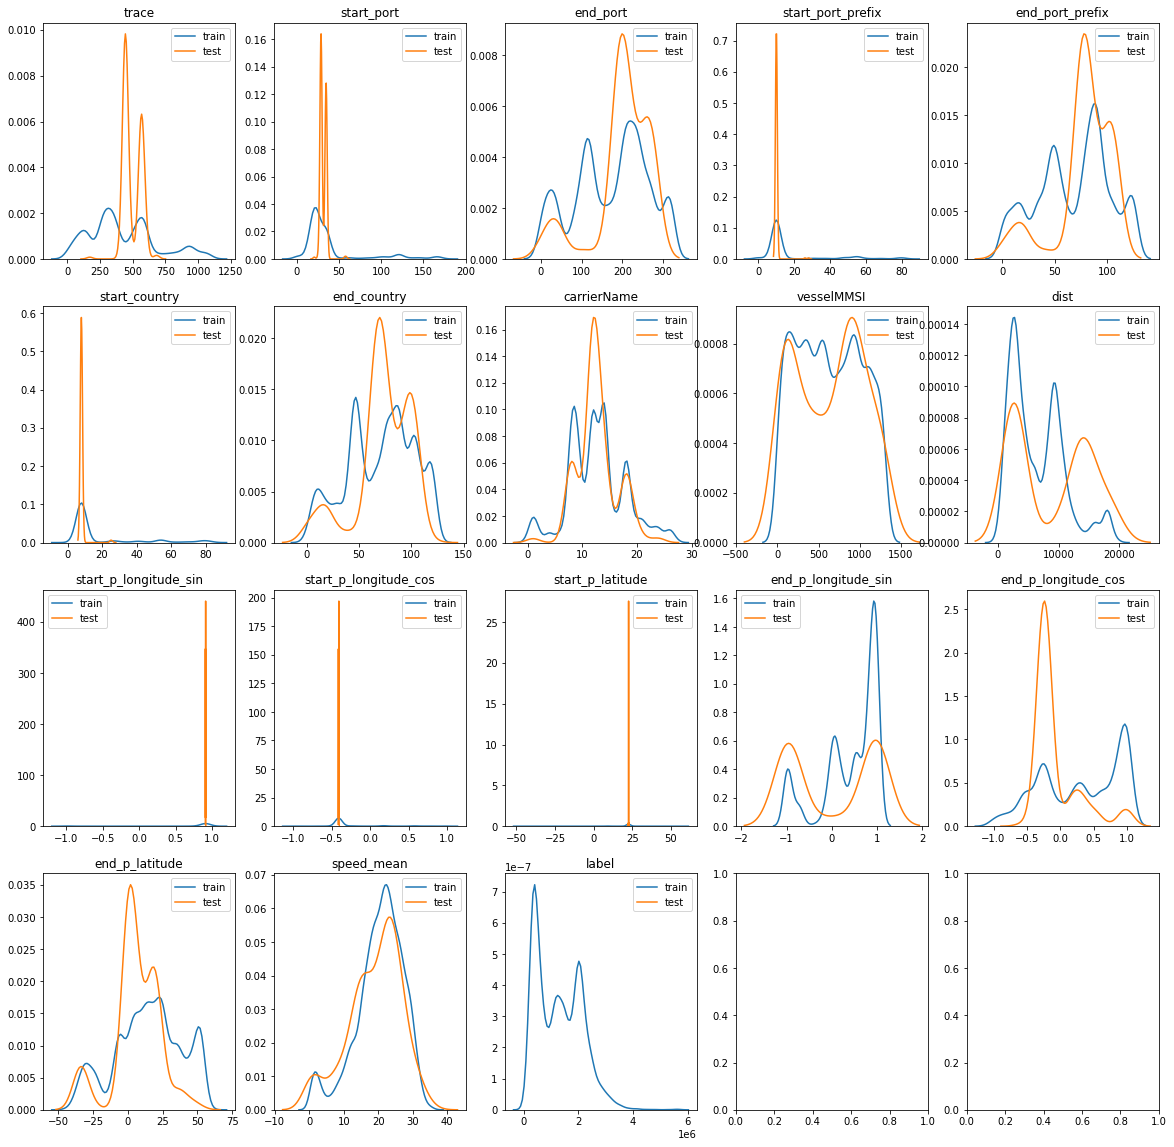

In [41]:
# 查看训练集与测试集特征分布
plt.subplots(4,5,figsize=(20,20))
for idx,col in enumerate(test_ft.columns):
    plt.subplot(4,5,idx+1)
    plt.title(col)
    sns.kdeplot(train_ft[col],label='train')
    sns.kdeplot(test_ft[col],label='test')

In [32]:
def run_cbt_cv(train_X,train_Y,test_X,feature_name=None,split=5,seed=2020666,cat_list=None):

    train_pred = np.zeros(train_X.shape[0])
    test_pred = np.zeros(test_X.shape[0])
    seeds=range(seed,seed+split)

    train_val_spliter = KFold(n_splits=split, random_state=seeds[0], shuffle=True)
    
    for index, (train_index, test_index) in enumerate(train_val_spliter.split(train_X, train_Y)):
        print('fold:',index+1)
        val_result = []

        train_x, val_x, train_y, val_y = train_X[feature_name].iloc[train_index], train_X[feature_name].iloc[test_index], train_Y.iloc[train_index], train_Y.iloc[test_index]
        
        cbt_model = cbt.CatBoostRegressor(iterations=3000,learning_rate=0.05,max_depth=7,verbose=200,
                                   early_stopping_rounds=100,task_type='GPU',eval_metric='RMSE',loss_function='RMSE',
                                   cat_features=cat_list,random_state=seeds[index],reg_lambda=1,use_best_model=True)
        cbt_model.fit(train_x[feature_name], train_y,eval_set=(val_x[feature_name],val_y))
        gc.collect()
        
        train_pred[test_index] += cbt_model.predict(val_x)
        fold_test_pred = cbt_model.predict(test_X[feature_name])
        test_pred += fold_test_pred/split
        
    print('test_label均值',np.mean(test_pred))
    print('train_label均值',np.mean(train_pred))
    print('MSE: ',mean_squared_error(train_Y,train_pred))
    return train_pred,test_pred

In [40]:
feature_names

['trace',
 'start_port',
 'end_port',
 'start_port_prefix',
 'end_port_prefix',
 'start_country',
 'end_country',
 'carrierName',
 'vesselMMSI',
 'dist',
 'start_p_longitude_sin',
 'start_p_longitude_cos',
 'start_p_latitude',
 'end_p_longitude_sin',
 'end_p_longitude_cos',
 'end_p_latitude',
 'speed_mean']

In [72]:
# baseline
feature_names = [c for c in train_ft.columns if c not in ['loadingOrder','label','onboardDate']]
%time train_pred,test_pred = run_cbt_cv(train_ft,train_y/3600,test_ft,feature_name=feature_names,cat_list=cat_cols)

fold: 1
0:	learn: 221.5159709	test: 222.2802257	best: 222.2802257 (0)	total: 43.1ms	remaining: 1m 47s
100:	learn: 79.6234654	test: 78.3735444	best: 78.3735444 (100)	total: 4.13s	remaining: 1m 38s
200:	learn: 65.6478683	test: 66.6874729	best: 66.6874729 (200)	total: 8.29s	remaining: 1m 34s
300:	learn: 58.1032643	test: 60.6980776	best: 60.6980776 (300)	total: 12.6s	remaining: 1m 32s
400:	learn: 53.3880366	test: 57.2438956	best: 57.2438956 (400)	total: 17.3s	remaining: 1m 30s
500:	learn: 50.7040020	test: 55.3110508	best: 55.3110508 (500)	total: 21.5s	remaining: 1m 25s
600:	learn: 48.4515438	test: 53.8552933	best: 53.8552933 (600)	total: 25.5s	remaining: 1m 20s
700:	learn: 46.7223913	test: 52.6982046	best: 52.6982046 (700)	total: 29.6s	remaining: 1m 15s
800:	learn: 45.2137961	test: 51.7142947	best: 51.7142947 (800)	total: 33.6s	remaining: 1m 11s
900:	learn: 44.1803665	test: 51.0543071	best: 51.0543071 (900)	total: 37.5s	remaining: 1m 6s
1000:	learn: 43.2771785	test: 50.4111490	best: 50.411

600:	learn: 50.7444431	test: 50.3119496	best: 50.3119496 (600)	total: 25.7s	remaining: 1m 21s
700:	learn: 48.8767708	test: 49.0449523	best: 49.0449523 (700)	total: 29.7s	remaining: 1m 16s
800:	learn: 47.5684279	test: 48.2074935	best: 48.2074935 (800)	total: 33.7s	remaining: 1m 11s
900:	learn: 46.6106802	test: 47.5772665	best: 47.5772665 (900)	total: 37.8s	remaining: 1m 7s
1000:	learn: 45.7039049	test: 46.9971109	best: 46.9971109 (1000)	total: 41.7s	remaining: 1m 2s
1100:	learn: 44.7553412	test: 46.4779407	best: 46.4779407 (1100)	total: 45.6s	remaining: 58s
1200:	learn: 43.8100448	test: 45.9523525	best: 45.9523525 (1200)	total: 49.6s	remaining: 53.7s
1300:	learn: 43.0751136	test: 45.5250797	best: 45.5250797 (1300)	total: 53.8s	remaining: 49.5s
1400:	learn: 42.5977702	test: 45.2236142	best: 45.2195139 (1399)	total: 57.3s	remaining: 45s
1500:	learn: 42.2425580	test: 45.0387489	best: 45.0387489 (1500)	total: 1m	remaining: 40.6s
1600:	learn: 41.9421596	test: 44.8504227	best: 44.8503918 (159

In [33]:
feature_names = [c for c in train_ft.columns if c not in ['loadingOrder','label','onboardDate']]
%time train_pred,test_pred = run_cbt_cv(train_ft,train_y/3600,test_ft,feature_name=feature_names,cat_list=cat_cols)

fold: 1
0:	learn: 221.5159709	test: 222.2802257	best: 222.2802257 (0)	total: 41.6ms	remaining: 2m 4s
200:	learn: 65.6478683	test: 66.6874729	best: 66.6874729 (200)	total: 8.28s	remaining: 1m 55s
400:	learn: 53.3880366	test: 57.2438956	best: 57.2438956 (400)	total: 16.8s	remaining: 1m 49s
600:	learn: 48.4515438	test: 53.8552933	best: 53.8552933 (600)	total: 25.3s	remaining: 1m 41s
800:	learn: 45.2137961	test: 51.7142947	best: 51.7142947 (800)	total: 33.4s	remaining: 1m 31s
1000:	learn: 43.2771785	test: 50.4111490	best: 50.4111490 (1000)	total: 41.2s	remaining: 1m 22s
1200:	learn: 41.9393382	test: 49.5474567	best: 49.5474567 (1200)	total: 48.8s	remaining: 1m 13s
1400:	learn: 40.6857358	test: 48.6377230	best: 48.6377230 (1400)	total: 56.4s	remaining: 1m 4s
1600:	learn: 39.8995804	test: 47.9769061	best: 47.9769061 (1600)	total: 1m 3s	remaining: 55.5s
1800:	learn: 39.2314415	test: 47.5053662	best: 47.5053662 (1800)	total: 1m 10s	remaining: 47.1s
2000:	learn: 38.7891892	test: 47.2369881	best

In [34]:
result = pd.DataFrame()
test_df = test_data[['loadingOrder','onboardDate']].drop_duplicates().reset_index(drop=True)
result['ETA'] = (test_df.onboardDate+pd.Series([pd.Timedelta(hours=t) for t in test_pred])).apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
result['loadingOrder'] = test_df['loadingOrder']
result = pd.merge(pd.read_csv('data/testData 0626.csv'),result,how='left',on='loadingOrder')
result['creatDate'] = pd.datetime.now().strftime('%Y/%m/%d  %H:%M:%S')

result = result[['loadingOrder', 'timestamp', 'longitude', 'latitude', 'carrierName', 'vesselMMSI', 'onboardDate', 'ETA', 'creatDate']]

d:\tools\python\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [35]:
# 计算label分布
def cal_label(best):
    onboardDate = best.groupby('loadingOrder')['onboardDate'].agg(mmax='max').reset_index()
    ETA=best.groupby('loadingOrder')['ETA'].agg(mmax='max').reset_index()
    return (pd.to_datetime(ETA['mmax'])-pd.to_datetime(onboardDate['mmax'])).dt.total_seconds()


test_label均值 415.99835976795396
train_label均值 361.1457747406241


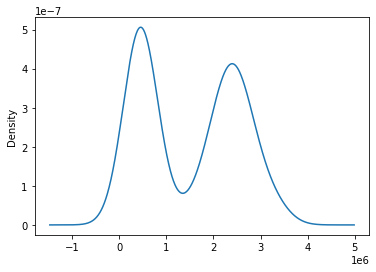

In [75]:
# baseline
print('test_label均值',np.mean(test_pred))
print('train_label均值',np.mean(train_pred))
new=cal_label(result)
new.plot(kind='kde')
plt.show()

test_label均值 415.2218578174436
train_label均值 361.09621773194476


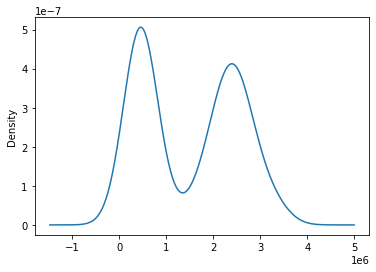

In [36]:
print('test_label均值',np.mean(test_pred))
print('train_label均值',np.mean(train_pred))
new=cal_label(result)
new.plot(kind='kde')
plt.show()

In [37]:
import datetime
now = datetime.datetime.now()
result.to_csv('result/result_{0}-{1}-{2}_{3}-{4}.csv'.format(now.year,now.month,now.day,now.hour,now.minute), index=False)

In [38]:
a = result[['loadingOrder','onboardDate', 'ETA']]
a['route'] = test_data.reset_index()['TRANSPORT_TRACE']
a['label'] = pd.to_datetime(a['ETA']) - pd.to_datetime(a['onboardDate'])
a[a['route']=='CNSHK-MYTPP'].groupby('loadingOrder').max()

d:\tools\python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
d:\tools\python\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,onboardDate,ETA,route,label
loadingOrder,,,,
AJ338174323933,2020/03/01 13:32:08,2020/03/08 18:50:43,CNSHK-MYTPP,7 days 05:18:35
BP352489313005,2020/03/08 23:42:38,2020/03/14 23:31:49,CNSHK-MYTPP,5 days 23:49:11
CX921020302440,2019/12/30 21:55:18,2020/01/06 08:51:54,CNSHK-MYTPP,6 days 10:56:36
EH417316823657,2020/01/28 04:52:18,2020/02/01 02:10:12,CNSHK-MYTPP,3 days 21:17:54
EO389054510734,2020/01/24 06:36:58,2020/01/30 20:37:24,CNSHK-MYTPP,6 days 14:00:26
EP955322386383,2020/01/28 04:52:18,2020/02/01 02:08:11,CNSHK-MYTPP,3 days 21:15:53
ES509695023954,2020/02/16 08:32:38,2020/02/20 09:37:25,CNSHK-MYTPP,4 days 01:04:47
FB514237413831,2020/01/24 06:36:58,2020/01/30 04:53:33,CNSHK-MYTPP,5 days 22:16:35
FC483811239672,2019/11/01 09:27:08,2019/11/08 08:12:35,CNSHK-MYTPP,6 days 22:45:27


In [39]:
result

,loadingOrder,timestamp,longitude,latitude,carrierName,vesselMMSI,onboardDate,ETA,creatDate
0,AE223035353902,2019-07-03T21:16:48.000Z,120.093858,22.581320,OIEQNT,C2075927370,2019/07/02 04:12:48,2019/07/29 07:55:36,2020/06/28 17:58:20
1,AE223035353902,2019-07-03T21:34:48.000Z,120.035707,22.617522,OIEQNT,C2075927370,2019/07/02 04:12:48,2019/07/29 07:55:36,2020/06/28 17:58:20
2,AE223035353902,2019-07-03T21:51:18.000Z,119.981800,22.658465,OIEQNT,C2075927370,2019/07/02 04:12:48,2019/07/29 07:55:36,2020/06/28 17:58:20
3,AE223035353902,2019-07-03T21:54:18.000Z,119.970845,22.668688,OIEQNT,C2075927370,2019/07/02 04:12:48,2019/07/29 07:55:36,2020/06/28 17:58:20
4,AE223035353902,2019-07-03T22:11:08.000Z,119.953628,22.756897,OIEQNT,C2075927370,2019/07/02 04:12:48,2019/07/29 07:55:36,2020/06/28 17:58:20
...,...,...,...,...,...,...,...,...,...
34707,ZZ524449869421,2020-03-17T04:02:38.000Z,103.776707,1.252897,BHSOUA,P2595193878,2020/03/13 06:07:28,2020/04/03 05:56:26,2020/06/28 17:58:20
34708,ZZ524449869421,2020-03-17T04:03:18.000Z,103.776312,1.253418,BHSOUA,P2595193878,2020/03/13 06:07:28,2020/04/03 05:56:26,2020/06/28 17:58:20
34709,ZZ524449869421,2020-03-17T04:05:18.000Z,103.775175,1.254865,BHSOUA,P2595193878,2020/03/13 06:07:28,2020/04/03 05:56:26,2020/06/28 17:58:20
34710,ZZ524449869421,2020-03-17T04:05:58.000Z,103.774803,1.255285,BHSOUA,P2595193878,2020/03/13 06:07:28,2020/04/03 05:56:26,2020/06/28 17:58:20
